# SST-Taux feedback : 

Computes zonal wind stress anomalies (TauxA) in the western equatorial Pacific (horizontal Niño4 average) regressed onto sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux 1979-2018 (main)

SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023
Taux: ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [2]:
model_ts_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20140101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

#tauu
model_tauu = {"ACCESS-ESM1-5": 
    model_ts_datasets["ACCESS-ESM1-5"].copy(short_name='tauu',mip="Amon")}
model_tauu["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

model_ts_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}
obs_tauu_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [3]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/tauu/gn/v20191115/tauu_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 


In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [6]:
def sst_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    
    return cube


def taux_west(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [9]:
model_tos_prep = {name: sst_east(dataset) for name, dataset in model_ts_datasets.items()}
model_tauu_prep = {name: taux_west(dataset) for name, dataset in model_tauu.items()}

obs_tos_prep = {name: sst_east(dataset) for name, dataset in obs_tos_datasets.items()}
obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

## Calculate Linear regression

In [10]:
# scp.LinReg(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data).intcpt
def linreg_1d(tauu_cube, ts_cube):
    B_data = ts_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, tauu_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

print(linreg_1d(model_tauu_prep["ACCESS-ESM1-5"], model_tos_prep["ACCESS-ESM1-5"]))


(2.5071893, -1.8271312e-07)


# Diagnostic Level 1

(1980,) (1980,)
(480,) (480,)
metric:60.74858903884888


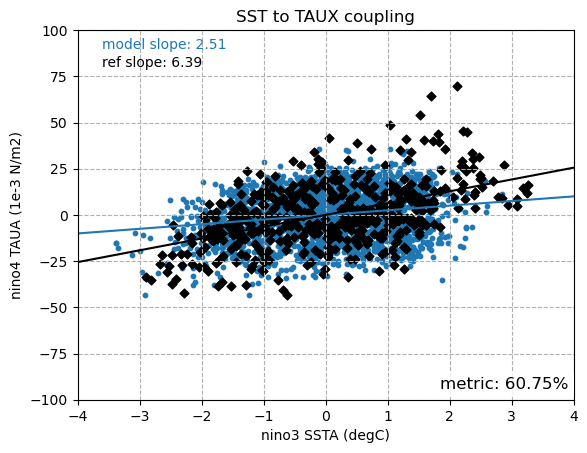

In [8]:

xseq = np.linspace(-4, 4, num=100)

# linregress(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data)
slope, intcpt = linreg_1d(model_tauu_prep["ACCESS-ESM1-5"], model_tos_prep["ACCESS-ESM1-5"])
plt.plot(xseq, intcpt+slope*xseq)
mod_slope = slope

slope, intcpt = linreg_1d( obs_tauu_prep["ERA-Interim"], obs_tos_prep["HadISST"])
plt.plot(xseq, intcpt+slope*xseq, color='black')
metric_val = abs((mod_slope-slope)/slope)*100

print(model_tauu_prep["ACCESS-ESM1-5"].shape, model_tos_prep["ACCESS-ESM1-5"].shape) #scatter plot
yunit = model_tauu_prep["ACCESS-ESM1-5"].units 
xunit = model_tos_prep["ACCESS-ESM1-5"].units
plt.scatter(model_tos_prep["ACCESS-ESM1-5"].data, model_tauu_prep["ACCESS-ESM1-5"].data, s=10)

print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')
plt.xlim(-4,4)
plt.ylim(-100,100)

plt.title('SST to TAUX coupling')
plt.ylabel(f'nino4 TAUA ({yunit})')
plt.xlabel(f'nino3 SSTA ({xunit})')
plt.grid(linestyle='--')
## text slope
plt.text(0.05,0.95, f'model slope: {mod_slope:.2f}', color='C0',transform=plt.gca().transAxes)
plt.text(0.05,0.9, f'ref slope: {slope:.2f}', color='black',transform=plt.gca().transAxes)

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
print(f'metric:{metric_val}')

Figure 1: scatterplot of sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged) and zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the strength of the SST-to-Taux coupling (usually too weak). The black and blue markers show respectively the reference and the model. The metric is based on the slope of the regression and is the absolute value of the relative difference: abs((model-ref)/ref)*100.

# Diagnostic Level 2

In [9]:
import pandas as pd

def linreg_df(ts, tauu):
    B_data = np.array(ts)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(tauu), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

def plt_lvl2_subplot(ts_cube, nhf_cube, dataset_label):
    
    df = pd.DataFrame({'tos':ts_cube.data, 'nhf':nhf_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(ts_cube.data, nhf_cube.data, c='k', s=10)
    xseq = np.linspace(-50, 50, num=50)
    slope, intcpt = linreg_df(df['tos'], df['nhf'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-50, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['tos']<0, 'tos'], df.loc[df['tos']<0, 'nhf'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 50, num=50)
    slope, intcpt = linreg_df(df.loc[df['tos']>0, 'tos'], df.loc[df['tos']>0, 'nhf'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

def plt_settings(slopes):
    plt.xlim(-4,4)
    plt.xticks(np.arange(-4,5,2))
    plt.ylim(-100,100)
    plt.yticks(np.arange(-100,120,50))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino4 TAUXA (1e-3 N/m2)')
    plt.xlabel(f'nino3 SSTA (°C)') #
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ACCESS-ESM1-5 shape:  (1980, 2)
[2.5071893, 6.7428226, -1.548706]
HadISST_ERA-Interim shape:  (480, 2)
[6.3875136, 10.196881, 8.813711]


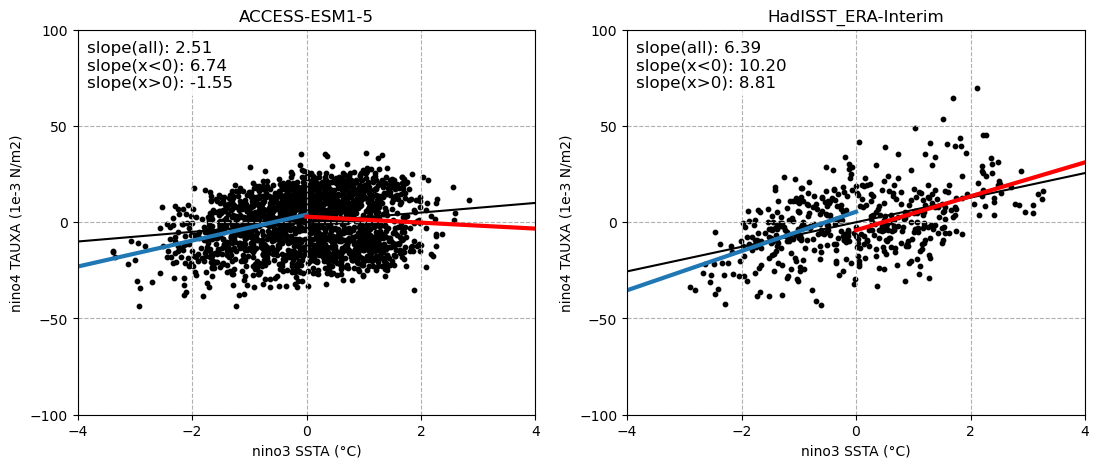

In [10]:
## plot figures
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"], 'ACCESS-ESM1-5')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_tos_prep["HadISST"], obs_tauu_prep["ERA-Interim"], 'HadISST_ERA-Interim')

Figure 2: scatterplot of sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged) and zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the possible nonlinearity in the strength of the SST-to-Taux coupling (usually shows no nonlinearity in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right scatterplots show respectively the reference and the model.

## Dive down level 3
The third level shows the remote coupling in the equatorial Pacific.

In [8]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics

def sst_east_3(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def taux_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 
#lin_regress

In [9]:
model_tos_prep = {name: sst_east_3(dataset) for name, dataset in model_ts_datasets.items()}
model_tauu_prep = {name: taux_eqp(dataset) for name, dataset in model_tauu.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [10]:
obs_tos_prep = {name: sst_east_3(dataset) for name, dataset in obs_tos_datasets.items()}
obs_tauu_prep = {name: taux_eqp(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [28]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeBsst.data.compressed() # masked threshold cube (time,)
    print(A_data.shape, B_data.shape)
    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    print(B_with_intercept.shape, A_data.shape)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,TAUXA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube
    
# reg2_mod = lin_regress_matrix(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
print(model_tos_prep["ACCESS-ESM1-5"].shape, model_tauu_prep["ACCESS-ESM1-5"].shape)

B_data = model_tos_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

# lin_regress_matrix(model_tauu_prep["ACCESS-ESM1-5"],model_tos_prep["ACCESS-ESM1-5"])

(420,) (420, 35)


In [31]:
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

# def plt_lvl3(ts_cube, nhf_cube, dataset_label):
    
#     df = pd.DataFrame({'tos':ts_cube.data, 'nhf':nhf_cube.data}) #nhf 2d (time, long)
#     slopes = []
#     print(dataset_label, 'shape: ', df.shape)

#     slope, intcpt = linreg_df(df['tos'], df['nhf'])
#     slopes.append(slope)
    
#     xseq = np.linspace(-50, 0, num=50) #
#     slope, intcpt = linreg_df(df.loc[df['tos']<0, 'tos'], df.loc[df['tos']<0, 'nhf'])
    
#     plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
#     slopes.append(slope)
    
#     xseq = np.linspace(0, 50, num=50)
#     slope, intcpt = linreg_df(df.loc[df['tos']>0, 'tos'], df.loc[df['tos']>0, 'nhf'])
#     plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
#     slopes.append(slope)


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)

    below0 = iris.Constraint(sea_surface_temperature=lambda cell: cell < 0)
    above0 = iris.Constraint(sea_surface_temperature=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

In [30]:
tau_cb.remove_coord('sea_surface_temperature')

In [29]:
model_tauu_prep["ACCESS-ESM1-5"].ancillary_variables()

sst_cb = model_tos_prep["ACCESS-ESM1-5"]
sst_cb.standard_name, sst_cb.long_name, sst_cb.var_name, sst_cb.attributes

sst_anc = iris.coords.AncillaryVariable(sst_cb.data, sst_cb.standard_name, sst_cb.long_name, sst_cb.var_name, sst_cb.units)
sst_anc

sst_coord = iris.coords.AuxCoord(sst_cb.data, sst_cb.standard_name, sst_cb.long_name, sst_cb.var_name, sst_cb.units)

tau_cb = model_tauu_prep["ACCESS-ESM1-5"]#.coord_dims('time')
# tau_cb.add_ancillary_variable(sst_anc, 0)

tau_cb

print(abs(tau_cb.data).sum(), mask_below_threshold(sst_cb.copy(), 0).shape)
#constraint
below0 = iris.Constraint(sea_surface_temperature=lambda cell: cell < 0) #63611.96
above0 = iris.Constraint(sea_surface_temperature=lambda cell: cell > 0)
# below0 = iris.Constraint(cube_func=lambda tau_cb: tau_cb.ancillary_variable('sea_surface_temperature').data > 0)

cube = tau_cb.extract(above0)
# tau_cb.ancillary_variable('sea_surface_temperature').data > 0
type(tau_cb.coord('time').points)
print(cube.shape)#, abs(cube.data).sum() #2223
ex = sst_cb.extract(above0) 
ex = mask_below_threshold(sst_cb.copy(), 0)
print(ex.data.compressed().shape)

lin_regress_matrix(cube, ex)


137432.62 (420,)
(223, 35)
(223,)
(223, 35) (223,)
(223, 2) (223, 35)


"Regression Ssta,Tauxa (unknown)",longitude
Shape,35
Dimension coordinates,
longitude,x


(197, 35) (197,)
(197, 2) (197, 35)
(223, 35) (223,)
(223, 2) (223, 35)


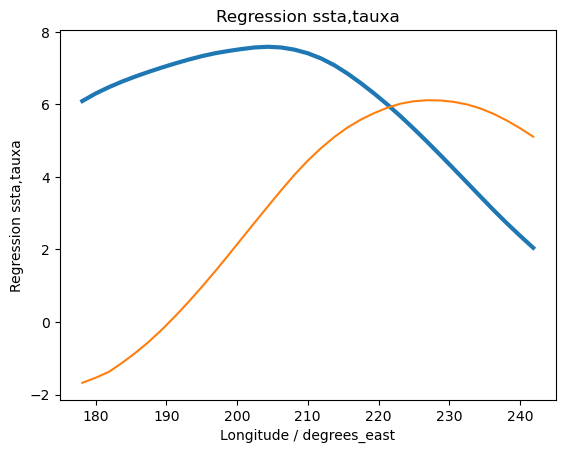

In [32]:
neg, pos = feedback_nonlin(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])

# combine cubes? aux

qplt.plot(neg, linewidth=3)
qplt.plot(pos)

(1980, 35) (1980,)
(1980, 2) (1980, 35)
(480, 132) (480,)
(480, 2) (480, 132)


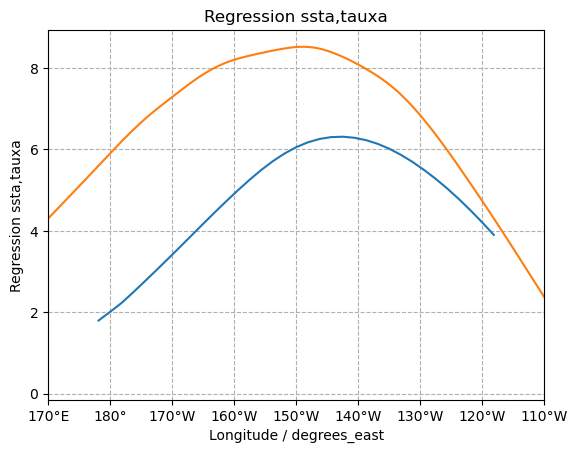

In [16]:
# tauu = model_tauu_prep["ACCESS-ESM1-5"].data
# coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, tauu, rcond=None)
cb = lin_regress_matrix(model_tauu_prep["ACCESS-ESM1-5"],model_tos_prep["ACCESS-ESM1-5"])

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        
qplt.plot(cb)

cb2 = lin_regress_matrix(obs_tauu_prep["ERA-Interim"], obs_tos_prep["HadISST"])
qplt.plot(cb2)

plt.xlim(170, 250)
plt.grid(linestyle='--')
# print(model_tauu_prep["ACCESS-ESM1-5"].coord('longitude').points)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

Figure 3: spatial structure of zonal wind stress anomalies (TauxA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regressed onto sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SST-to-Taux coupling (the reference shows the maximum coupling around the dateline, west of the dateline for SSTA<0, east of the dateline for SSTA>0, but the amplitude of the maximum coupling is about the same; usually the models do not reproduce the displacement of the maximum coupling for all SSTA, SSTA<0, SSTA>0 and simulate a weakening of the coupling for SSTA<0). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the dashed and solid curves show respectively the reference and the model.

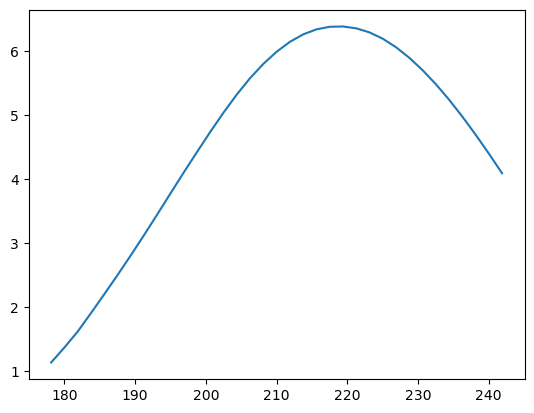

In [37]:
from scipy.stats import linregress
def lin_regress(cube_ssta, cube_nino34): #1d pattern
    slope_ls = []
    for lon_slice in cube_ssta.slices(['time']): 
        res = linregress(cube_nino34.data, lon_slice.data)
        slope_ls.append(res[0])

    return cube_ssta.coord('longitude').points, slope_ls

reg_mod = lin_regress( model_tauu_prep["ACCESS-ESM1-5"], model_tos_prep["ACCESS-ESM1-5"])
plt.plot(*reg_mod)